# Generative AI Models for Text Analysis

This is intended as a simple demo for how one can make use of the OpenAI API in research, without running heavy computations on your own machine.

This notebook is heavily based on content from the [OpenAI cookbook](https://cookbook.openai.com/).

We will:
1. Locally load a dataset of food reviews.
2. Use the OpenAI API to create a numerical vector "embedding" for the reviews.
3. Use our machine to reduce the dimensionality, visualise, and cluster the reviews.
4. Use the OpenAI API to summarise the clusters we have found.

If you don't have an OpenAI API key, you can still run this notebook, but you will not be able to use the API to generate embeddings or summaries and will have to rely on the pre-computed local results.

We only use simple models from OpenAI as a demo, but you can use the same approach to use more complex models.

## Setup

### 1. Sign up for OpenAI API access
OpenAI has developed various powerful Large Language Models. We can use the API to send data to these models and get back results. To do this, you will need to:
1. Sign up for an [account](https://openai.com/product).
2. Create an [API key](https://platform.openai.com/api-keys) and save it (below).
3. Add your [billing details](https://platform.openai.com/account/billing/overview) and top-up your account. This notebook costs a few cents to run.

If you just want to explore the results in this notebook, and not have to worry about setting up API access, set `USE_API = False` below.

### 2. Install dependencies

To run this notebook, you will need to install: `python-dotenv`, `pandas`, `openai`, `tiktoken`, `tenacity`, `matplotlib`, `scikit-learn`, and `scipy`.

Use `pip install` or `conda install` in your terminal to install these packages if they are not already present.

### 3. Setup this notebook with necessary libraries and API key

In [1]:
# import utility libraries
import os
import pickle
from ast import literal_eval
from dotenv import load_dotenv

# import data analysis libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib

# import OpenAI libraries
from openai import OpenAI
import tiktoken
from utils.embeddings_utils import get_embedding # included in repo

In [2]:
## Uncomment the following code to set up your OpenAI API key.
## You will need to have an OpenAI account and have created an API key.
## You can do so here: https://platform.openai.com/api-keys
## You will only need to do this once. Afterwards, delete the cell

# # Load the environment variables from .env file
# # Enter your API key, never share this or upload to GitHub
# # Make sure to add .env to your .gitignore file

# api_key = "..."

# # Save the API key to .env file
# with open(".env", "w") as f:
#     f.write(f"OPENAI_API_KEY={api_key}")

In [3]:
# Load the environment variables (inc. API key) from .env file
load_dotenv()

# Set whether to re-query the OpenAI API (True), or load data from disk (False)
USE_API = False

## Get embeddings from dataset [[1]](https://github.com/openai/openai-cookbook/blob/main/examples/Get_embeddings_from_dataset.ipynb)

### 1. Load the dataset

The dataset used in this example is [fine-food reviews](https://www.kaggle.com/snap/amazon-fine-food-reviews) from Amazon. The dataset contains a total of 568,454 food reviews Amazon users left up to October 2012. We will use a subset of this dataset, consisting of 1,000 most recent reviews for illustration purposes. The reviews are in English and tend to be positive or negative. Each review has a ProductId, UserId, Score, review title (Summary) and review body (Text).

We will combine the review summary and review text into a single combined text. The model will encode this combined text and it will output a single vector embedding. In layman's terms, the model converts the human readable text of each review into a sequence of numbers. These numbers represent the meaning of the text. Reviews which are similar in meaning will have similar numbers in their embeddings and will be measurably 'close' to one another.

In [4]:
# load & inspect dataset
input_datapath = "data/fine_food_reviews_1k.csv"  # to save space, we provide a pre-filtered dataset
df = pd.read_csv(input_datapath, index_col=0) # read the csv
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]] # select specific columns
df = df.dropna() # drop rows with missing values

# combine title and content in a new column
df["combined"] = ("Title: " + df.Summary.str.strip()
                  + "; Content: " + df.Text.str.strip())

# inspect the first five rows
df.head(5)


,Time,ProductId,UserId,Score,Summary,Text,combined
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...
2,1351123200,B000JMBE7M,AQX1N6A51QOKG,4,"It isn't blanc mange, but isn't bad . . .",I'm not sure that custard is really custard wi...,"Title: It isn't blanc mange, but isn't bad . ...."
3,1351123200,B004AHGBX4,A2UY46X0OSNVUQ,3,These also have SALT and it's not sea salt.,I like the fact that you can see what you're g...,Title: These also have SALT and it's not sea s...
4,1351123200,B001BORBHO,A1AFOYZ9HSM2CZ,5,Happy with the product,My dog was suffering with itchy skin. He had ...,Title: Happy with the product; Content: My dog...


In [5]:
# Specify embedding model parameters
embedding_model = "text-embedding-ada-002" # more options here: https://platform.openai.com/docs/guides/embeddings/embedding-models
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191

In [6]:
# subsample to 1k most recent reviews and remove samples that are too long
top_n = 1000
df = df.sort_values("Time").tail(top_n * 2)  # first cut to first 2k entries
df.drop("Time", axis=1, inplace=True) # drop time column

encoding = tiktoken.get_encoding(embedding_encoding) # get the encoding

# omit reviews that are too long to embed
# get the number of tokens in each review according to the encoding
df["n_tokens"] = df["combined"].apply(lambda x: len(encoding.encode(x))) 
df = df[df["n_tokens"] <= max_tokens].tail(top_n) # drop reviews that are too long, then take the last top_n entries
len(df)


1000

### 2. Get embeddings and save them for future reuse

In [7]:
# Query the OpenAI API to get the embeddings
# This may take a few minutes
# This also costs money (several cents with default settings) from your OpenAI API balance
# Set USE_API to False to load the embeddings from disk instead
if USE_API:
    print("Querying the OpenAI API to get the embeddings...")
    df["embedding"] = df["combined"].apply(lambda x: get_embedding(x, model=embedding_model))
    df.to_csv("data/fine_food_reviews_with_embeddings_1k.csv") # save the data to disk
else:
    print("Loading the embeddings from disk...")
    df = pd.read_csv("data/fine_food_reviews_with_embeddings_1k.csv", index_col=0)
    df["embedding"] = df["embedding"].apply(literal_eval) # convert string to list in embedding column

Loading the embeddings from disk...


## Visualizing the embeddings in 2D [[2]](https://github.com/openai/openai-cookbook/blob/main/examples/Visualizing_embeddings_in_2D.ipynb)

We will use t-SNE, a common dimension reduction technique, to visualize the embeddings in 2D (rather than the original 1536 dimensions). Once the embeddings are reduced to two dimensions, we can plot them in a 2D scatter plot.

### 1. Reduce dimensionality

We reduce the dimensionality to 2 dimensions using t-SNE decomposition.

In [8]:
# Convert embedding scores in df to an array of floats
matrix = np.array(df["embedding"].to_list())

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix) # transform the data
vis_dims.shape # check the shape of the output - 1000 obs, 2 dimensions

(1000, 2)

### 2. Plotting the embeddings

We colour each review by its star rating.

We can observe a decent data separation, albeit not by rating, even in the reduced 2 dimensions.

Text(0.5, 1.0, 'Amazon ratings visualized in language using t-SNE')

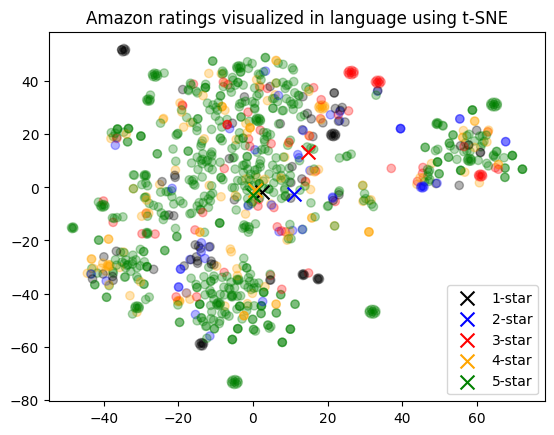

In [9]:
# colors for star ratings
colors = ["black", "blue", "red", "orange", "green"]
x = vis_dims[:,0] # x and y coordinates
y = vis_dims[:,1]
color_indices = df.Score.values - 1

colormap = matplotlib.colors.ListedColormap(colors) # create a colormap from the colors
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3) # plot the data

# add cluster centers
for score in [0,1,2,3,4]:
    avg_x = x[df["Score"]-1==score].mean()
    avg_y = y[df["Score"]-1==score].mean()
    color = colors[score]
    plt.scatter(avg_x, avg_y, marker='x', color=color, s=100, label = f'{score+1}-star')
plt.legend()

plt.title("Amazon ratings visualized in language using t-SNE")

The major visible clusters don't seem to be associated with the star rating. This is expected, as the model is trained to encode the meaning of the text, not the star rating or solely sentiment. There is perhaps some hyperlocal clustering in certain cases, but it is not very clear. Let's see what the apparent clusters actually relate to...

## K-means Clustering in Python using OpenAI [[3]](https://github.com/openai/openai-cookbook/blob/main/examples/Clustering.ipynb)

We use a simple k-means algorithm to demonstrate how clustering can be done. Clustering can help discover valuable, hidden groupings within the data. We cluster based on all 1536 dimensions of the embeddings. Then we plot the clusters in 2D using t-SNE.

### 1. Find the clusters using K-means

We show the simplest use of K-means. You can pick the number of clusters that fits your use case best.

In [10]:
n_clusters = 4 # decide on the number of clusters

# fit the k-means model
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels # add the cluster labels to the dataframe

df.groupby("Cluster")["Score"].mean().sort_values() # check the average star rating per cluster

/Users/Patrick/Documents/LSE/Projects/genai-tools/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster
3    4.046809
1    4.191176
2    4.212687
0    4.340720
Name: Score, dtype: float64

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

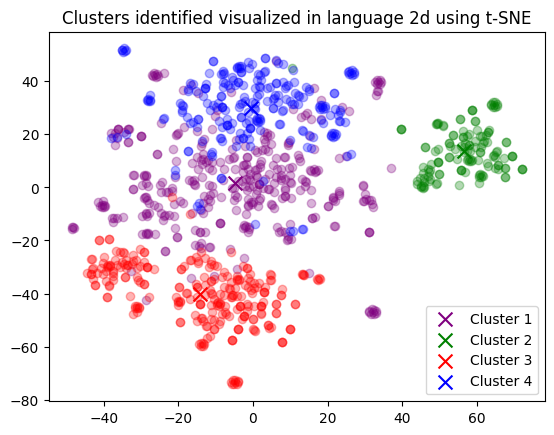

In [11]:
# using t-SNE dimensions from before (x, y)

# plot each cluster in different colour
for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = x[df["Cluster"] == category]
    ys = y[df["Cluster"] == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    # add cluster center
    avg_x = xs.mean()
    avg_y = ys.mean()
    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100, label=f'Cluster {category+1}')

plt.legend()
plt.title("Clusters identified visualized in language 2d using t-SNE")

Visualization of clusters in a 2d projection. In this run, the green cluster (#1) seems quite different from the others. Let's see a few samples from each cluster.

### 2. Text samples in the clusters & naming the clusters

Let's show random samples from each cluster. We'll query OpenAI API again, with model `text-davinci-003`, to decribe the clusters, based on a random sample of 5 reviews from that cluster. More reviews or a more sophisticated model (`gpt-4`, `gpt-3.5-turbo`) can be used to get a better description, since the default descriptions are quite generic.

In [15]:
if USE_API: # Query the OpenAI API to get the theme for each cluster
    # This also costs money (several cents with default settings) from your OpenAI API balance

    # Create a dictionary to save the results
    summary_dict = {n+1: {} for n in range(n_clusters)}
    # Create OpenAI API client
    client = OpenAI()

    rev_per_cluster = 5 # Select 5 random reviews per cluster
    for i in range(n_clusters): # for each cluster
        # sample 5 random reviews from the cluster, combine them into a single string
        reviews = "\n".join(
            df[df["Cluster"] == i]
            .combined.str.replace("Title: ", "")
            .str.replace("\n\nContent: ", ":  ")
            .sample(rev_per_cluster, random_state=42)
            .values
        )

        # Send the prompt to the API, with the reviews
        # This is very conceptually similar to simply pasting the prompt and reviews into ChatGPT
        response = client.completions.create(
            model="text-davinci-003", # choose which model to use
            prompt=f'What do the following customer reviews have in common?\n\nCustomer reviews:\n"""\n{reviews}\n"""\n\nTheme:',
            temperature=0, # parameters for the model - this results in a deterministic, non-creative response
            max_tokens=64,
            top_p=1, 
            frequency_penalty=0,
            presence_penalty=0,
        )
        summary_dict[i+1]["theme"] = response.choices[0].text.replace("\n", "") # save the theme

        # Also save the sampled reviews
        sample_cluster_rows = df[df["Cluster"] == i].sample(rev_per_cluster, random_state=42)
        samp_dict = {} # create a dictionary to save the sampled reviews
        for j in range(rev_per_cluster):
            score = sample_cluster_rows["Score"].values[j] # get the score
            summary = sample_cluster_rows["Summary"].values[j] # get the summary
            text = sample_cluster_rows["Text"].values[j] # get the text
            samp_dict[j] = (score, summary, text) # save the sampled review

        # save the sampled reviews
        summary_dict[i+1]["samples"] = samp_dict
    
    # Save the results to disk
    with open("data/summary_dict.pkl", "wb") as f:
        pickle.dump(summary_dict, f)

else: # alternatively, load the results from disk
    print("Loading existing summary dict\n")
    with open("data/summary_dict.pkl", "rb") as f:
        summary_dict = pickle.load(f)

# Print results
for i in range(n_clusters): # for each cluster
    print(f"Cluster {i+1} Theme:", end=" ")
    print(summary_dict[i+1]["theme"]) # print the theme
    for j in range(len(summary_dict[i+1]["samples"])): # for each sampled review
        score, summary, text = summary_dict[i+1]["samples"][j] # get the score, summary, and text
        print(f"{score}/5 {summary}:   {text}"[:97] + "...") # print the sampled review
    print("-" * 100) # print a line break
   

Loading existing summary dict

Cluster 1 Theme:  All of the reviews are discussing food or drink products.
3/5 Just ok:   I bought this brand because it was all they had at Ranch 99 near us. I find it spi...
5/5 Makes me drool just thinking of them:   The Brit's have out done us. The flavor is supreme,th...
5/5 Delicious way to flavour water naturally without too many calories:   I love the Flavrz range...
1/5 Couldn't tell you how it tasted:   The bottle was not sealed, and when I opened the cover, th...
5/5 Great tasting:   This is awesome salt. I buy it over and over as I just love the maltiness fl...
----------------------------------------------------------------------------------------------------
Cluster 2 Theme:  All of the reviews are about pet food.
2/5 Messy and apparently undelicious:   My cat is not a huge fan. Sure, she'll lap up the gravy, ...
4/5 The cats like it:   My 7 cats like this food but it is a little yucky for the human. Pieces o...
5/5 cant get enough of it!!!

It's important to note that clusters will not necessarily match what you intend to use them for. A larger amount of clusters will focus on more specific patterns, whereas a small number of clusters will usually focus on largest discrepencies in the data.

Nevertheless, the simple `text-davinci-003` model with 5 reviews has identified some meaning from the data. Most notably is the distinct cluster 2, which contains reviews about pet food.

## Conclusion

We have shown how to use the OpenAI API to generate embeddings for a dataset of food reviews. We have then used our machine to reduce the dimensionality of the embeddings, visualise them, and cluster them. Finally, we have used the OpenAI API again to summarise the clusters we have found.